In [131]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib, collections
from scipy.stats import norm
import imp, os, pickle
import warnings
import sys
import math
from matplotlib import collections  as mc
from scipy.stats import poisson
warnings.filterwarnings("ignore")
from scipy.stats import norm
sns.set(style="white")
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

## Parameters

In [132]:
f = 0.1 #Mining rate
m = 200 #Number of voting chains
log_epsilon = 20 #Confirmation guarantee

'''
Number of public proposal block
proposer_block[0] is mined by honest node, proposer_block[1] is mined by adversarial node
proposer_block[0] is A in the report, proposer_block[1] is B in the report
'''
proposer_blocks = 2 

beta_actual = 0.05 # probability with which an incoming voting block has been mined by adversary

'''
probability of choosing proposal block A and B, respectively, by honest nodes.
'''
prob_selecting_proposer_blocks_by_honest_nodes = [0.4, 0.6] 


beta_calc = np.array([0.1, 0.15, 0.2, 0.25, .3, .35, 0.4]) # probability using which V_estimate is calculated

## Prism Latency Simulation

In [142]:
# Number of adverserial blocks in private at time t
def adverserial(t, beta, fv):
    x = np.arange(0,3000,1)
    mu = fv*t*beta/(1-beta)
    return poisson.pmf(x, mu)

#Probability that a vote with depth k will be removed when adversary has Z_t blocks in private
def p_k_t(k, Z_t,beta):
    ans = 0
    k = int(k)
    for i in range(k):
        ans += Z_t[i]*np.power(beta/(1-beta), k - i)
    ans += np.sum(Z_t[k:])
    return ans

def runExp(m, log_epsilon, fv, proposer_blocks, prob_selecting_proposer_blocks_by_honest_nodes, beta_calc, beta_actual):
    events = int(20000*log_epsilon)
    time_array_for_list_confirmation = np.zeros_like(beta_calc)
    time_array_for_unique_block_confirmation = np.zeros_like(beta_calc)
    fv_effective = fv/(1.0+2*fv) #Forking
    exp_random_v = np.random.exponential(1/(m*fv_effective), size=events)
    chain_random_v = np.random.randint(m, size=events)
    
    
    '''
    Determining whether the mined block at each event is from an honest node or from an adversary
    Each element is associated with an event of mining a block 
    Each element specifies whether the block is mined by adversary or honest node
    '''
    mined_by_adversary_or_honest_node = np.random.choice(['Honest', 'Adversary'], events, p = [1 - beta_actual, beta_actual])
    

    
    for j, beta in enumerate(beta_calc):
#         exponent = 0.8*(1-2*beta)/(1-beta)*np.log((1-beta)/beta)

        print('beta')
        print(beta)
        
        # the following variables are used for the computation of \underbar{V}_{n}(r)
        votes_permanence_E_A, votes_permanence_V_A =  np.zeros(m),  np.zeros(m)
        time_for_list_confirmation, time_for_unique_block_confirmation, mean_A, var_A  = 0,0,0,0
        votes_permanence_E_B, votes_permanence_V_B =  np.zeros(m),  np.zeros(m)
        mean_B, var_B  = 0,0        
        list_confirmation_done = False # set it True when list confirmation done        
            
        '''
        The following vector contains proposal block voted by each of the voter chain
        It can be updated everytime a voter block is mined 
        (specifically, in case of tie in length of competing forked chains)
        Initially, no voter block has been mined and so no voting yet, thus, initializing with None
        If proposal_block_selected_by_voter_chain[rChain] = 0, then vote is for A
        If proposal_block_selected_by_voter_chain[rChain] = 1, then vote is for B
        '''
        proposal_block_selected_by_voter_chain = np.asarray([None]*m) 


        '''
        n_A is the number of votes for A in a chain along the voting tree
        n_B is the number of votes for B in a chain along the voting tree
        Initially, no votes cast, so, initialized with 0
        '''
        n_A = np.zeros(m)
        n_B = np.zeros(m)
        
        
        
        
        
        for i, tDiff in enumerate(exp_random_v):
            # print(i)
            # incrementing time
            # if beta == 0.4:
            #    print(i)
            
            time_for_unique_block_confirmation += tDiff
            
            if list_confirmation_done == False:
                time_for_list_confirmation += tDiff
                
            
            # Selecting the chain to add the voting block (by sortition)
            rChain = chain_random_v[i]
            
            flipping  = False # indicates whether the vote from a voter chain has flipped or not due to balancing attack
            
            '''
            (1) Determining whether adversary mined the block or honest node mined the block
            (2) Determining where the vote gets added among the two competing forked voter chains
            '''

            
            
            if mined_by_adversary_or_honest_node[i] == 'Adversary':                    
                # block mined by adversary votes for the shorter of the chain
                # the adversary doesn't change the vote
                if n_A[rChain] > n_B[rChain]:
                    n_B[rChain] += 1
                elif n_A[rChain] < n_B[rChain]:
                    n_A[rChain] += 1
                else:
                    '''
                    The case for n_A[rChain] = n_B[rChain]
                    The adversary would try to balance the total number of votes 
                    '''                    
                    number_of_votes_for_A_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 0)
                    number_of_votes_for_B_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)
                    
                    # Balance the number of votes for the proposer blocks
                    if number_of_votes_for_A_currently > number_of_votes_for_B_currently:
                        '''
                        flipping
                        possible only when adversary is changing the existing vote, that is, the existing vote was 
                        proposal_block_selected_by_voter_chain[rChain] != 1 and 
                        proposal_block_selected_by_voter_chain[rChain] != None
                        '''
                        if proposal_block_selected_by_voter_chain[rChain] == 0:
                            flipping = True
                        
                        proposal_block_selected_by_voter_chain[rChain] = 1
                        n_B[rChain] += 1
                    elif number_of_votes_for_A_currently < number_of_votes_for_B_currently:
                        '''
                        flipping
                        possible only when adversary is changing the existing vote, that is, the existing vote was 
                        proposal_block_selected_by_voter_chain[rChain] != 0 and 
                        proposal_block_selected_by_voter_chain[rChain] != None
                        '''
                        if proposal_block_selected_by_voter_chain[rChain] == 1:
                            flipping = True
                            
                        proposal_block_selected_by_voter_chain[rChain] = 0
                        n_A[rChain] += 1
                    else: 
                        # Do nothing
                        pass
                
            else:
                # If mined by honest node, then we have following cases
                if n_A[rChain] > n_B[rChain]:
                    # Applying longest chain protocol
                    n_A[rChain] += 1
                elif n_A[rChain] < n_B[rChain]:
                    # Applying longest chain protocol
                    n_B[rChain] += 1
                else:
                    '''
                    The case for n_A[rChain] = n_B[rChain]
                    In globalised view, count the number of votes that A and B have obtained till now 
                    '''
                    number_of_votes_for_A_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 0)
                    number_of_votes_for_B_currently = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)
                    
                    # follow maximum vote protocol
                    if number_of_votes_for_A_currently > number_of_votes_for_B_currently:
                        '''
                        flipping
                        possible only when honest user is changing the existing vote, that is, the existing vote was
                        proposal_block_selected_by_voter_chain[rChain] != 0 and 
                        proposal_block_selected_by_voter_chain[rChain] != None
                        '''
                        if proposal_block_selected_by_voter_chain[rChain] == 1:
                            flipping = True                        
                        proposal_block_selected_by_voter_chain[rChain] = 0
                        n_A[rChain] += 1
                    elif number_of_votes_for_A_currently < number_of_votes_for_B_currently: 
                        '''
                        flipping
                        possible only when honest user is changing the existing vote, that is, the existing vote was 
                        proposal_block_selected_by_voter_chain[rChain] != 1 and 
                        proposal_block_selected_by_voter_chain[rChain] != None
                        '''                       
                        if proposal_block_selected_by_voter_chain[rChain] == 0:
                            flipping  = True
                        proposal_block_selected_by_voter_chain[rChain] = 1
                        n_B[rChain] += 1
                    else:
                        # random selection, a not so often scenario (not sure whether it is rare) 
                        proposal_block_selected = np.random.choice([0, 1], 1, p = prob_selecting_proposer_blocks_by_honest_nodes)
                        
                        
                        '''
                        flipping
                        possible only when honest user is changing the existing vote, that is, the existing vote was 
                        proposal_block_selected_by_voter_chain[rChain] != proposal_vote_selected and 
                        proposal_block_selected_by_voter_chain[rChain] != None
                        '''  
                        if (proposal_block_selected_by_voter_chain[rChain] != proposal_block_selected) and (proposal_block_selected_by_voter_chain[rChain] != None):
                            flipping  = True
                        
                        proposal_block_selected_by_voter_chain[rChain] = proposal_block_selected
                        if proposal_block_selected_by_voter_chain[rChain] == 0:
                            n_A[rChain] += 1
                        else:
                            n_B[rChain] += 1
                            
             
            
            
            if proposal_block_selected_by_voter_chain[rChain] == 0:
                '''
                Updating underbar_V_A
                '''
                #Solidified probability
                Z_t = adverserial(time_for_unique_block_confirmation, beta, fv)
                p_i = 1 - p_k_t(n_A[rChain], Z_t, beta)                

                # Updating the mean and variance
                mean_A -= votes_permanence_E_A[rChain]
                var_A  -= votes_permanence_V_A[rChain]            
                votes_permanence_E_A[rChain] = p_i  
                votes_permanence_V_A[rChain] = p_i*(1-p_i)            
                mean_A += votes_permanence_E_A[rChain]
                var_A  += votes_permanence_V_A[rChain]    
                
                
                if flipping == True:
                    '''
                    Updating underbar_V_B when there is flipping
                    Votes from rChain voter tree to proposer block B made 0
                    '''
                    mean_B -= votes_permanence_E_B[rChain]
                    var_B  -= votes_permanence_V_B[rChain]
                    votes_permanence_E_B[rChain] = 0
                    votes_permanence_V_B[rChain] = 0
                
            else:
                '''
                Updating underbar_V_B
                '''
                #Solidified probability
                Z_t = adverserial(time_for_unique_block_confirmation, beta, fv)
                p_i = 1 - p_k_t(n_B[rChain], Z_t, beta)                

                # Updating the mean and variance
                mean_B -= votes_permanence_E_B[rChain]
                var_B  -= votes_permanence_V_B[rChain]            
                votes_permanence_E_B[rChain] = p_i  
                votes_permanence_V_B[rChain] = p_i*(1-p_i)            
                mean_B += votes_permanence_E_B[rChain]
                var_B  += votes_permanence_V_B[rChain]  
                
                if flipping == True:
                    '''
                    Updating underbar_V_A when there is flipping
                    Votes from rChain voter tree to proposer block A made 0
                    '''
                    mean_A -= votes_permanence_E_A[rChain]
                    var_A  -= votes_permanence_V_A[rChain]
                    votes_permanence_E_A[rChain] = 0
                    votes_permanence_V_A[rChain] = 0
                
            
            print('new round')    

            underbar_V_A = mean_A - np.sqrt(2*var_A*log_epsilon)  
            print("underbar_V_A: {0:8.2f}".format(underbar_V_A))
            
            underbar_V_B = mean_B - np.sqrt(2*var_B*log_epsilon)              
            print("underbar_V_B: {0:8.2f}".format(underbar_V_B))
            
            overbar_V_private = m - underbar_V_A - underbar_V_B  
            print("overbar_V_private: {0:8.2f}".format(overbar_V_private))
            #----------------------------------------------------------------
            # This is for sanity check, ignore
            '''
            if math.isnan(underbar_V_A) == True:
                print("mean_A: {0:8.2f}".format(mean_A))
                print("var_A: {0:8.2f}".format(var_A))
                sys.exit()
            '''

            #----------------------------------------------------------------
    
    
            #----------------------------------------------------------------
            # This is for sanity check, ignore
            '''
            if math.isnan(underbar_V_B) == True:
                print("mean_B: {0:8.2f}".format(mean_B))
                print("var_B: {0:8.2f}".format(var_B))  
                sys.exit()
            '''
            #----------------------------------------------------------------

            
            # List confirmation policy
            if list_confirmation_done == False:
                if max(underbar_V_A, underbar_V_B) > overbar_V_private:
                    print('list_confirmed')
                    list_confirmation_done = True

                        
            
            
            
            
            
            
            
            
            # counting number of voter chains that haven't cast vote for any proposal block
            U_current = np.count_nonzero(proposal_block_selected_by_voter_chain == None)
            print("U_current: {0:8.2f}".format(U_current))
            
            # counting number of voter chains that currently casts vote for proposal block A
            V_A_current = np.count_nonzero(proposal_block_selected_by_voter_chain == 0) 
            print("V_A_current: {0:8.2f}".format(V_A_current))
            
            # counting number of voter chains that currently casts vote for proposal block B
            V_B_current = np.count_nonzero(proposal_block_selected_by_voter_chain == 1)             
            print("V_B_current: {0:8.2f}".format(V_B_current))
            
            '''
            Updating overbar_V_A
            '''
            overbar_V_A = V_A_current + (V_B_current - max(underbar_V_B , 0)) + U_current
            print("overbar_V_A: {0:8.2f}".format(overbar_V_A))
 

            #----------------------------------------------------------------
            # This is for sanity check, ignore
            '''
            if math.isnan(overbar_V_A) == True:
                print("V_A_current: {0:8.2f}".format(V_A_current))
                print("V_B_current: {0:8.2f}".format(V_B_current))
                print("U_current: {0:8.2f}".format(U_current))
                print("underbar_V_B: {0:8.2f}".format(underbar_V_B))
                sys.exit()
            '''
            #----------------------------------------------------------------


            '''
            Updating overbar_V_B
            '''
            overbar_V_B = V_B_current + (V_A_current - max(underbar_V_A , 0)) + U_current
            print("overbar_V_B: {0:8.2f}".format(overbar_V_B))
 

            #----------------------------------------------------------------
            # This is for sanity check, ignore
            '''
            if math.isnan(overbar_V_B) == True:
                print("V_A_current: {0:8.2f}".format(V_A_current))
                print("V_B_current: {0:8.2f}".format(V_B_current))
                print("U_current: {0:8.2f}".format(U_current))
                print("underbar_V_A: {0:8.2f}".format(underbar_V_A))
                sys.exit()
            '''
            #----------------------------------------------------------------


            

            # Unique block confirmation policy
            if (underbar_V_A > overbar_V_B) or (overbar_V_A < underbar_V_B):
                time_array_for_unique_block_confirmation[j] = time_for_unique_block_confirmation
                time_array_for_list_confirmation[j] = time_for_list_confirmation
                print('list is confirmed')
                print(list_confirmation_done)
                if list_confirmation_done == False:
                    sys.exit()
                print('List confirmation at: {0:8.2f}'.format(time_for_list_confirmation))
                print('Unique Block confirmation at: {0:8.2f}'.format(time_for_unique_block_confirmation))
                break
            

    print('time_array_for_list_confirmation')
    print(time_array_for_list_confirmation)
    print('time_array_for_unique_block_confirmation')
    print(time_array_for_unique_block_confirmation)
    return time_array_for_list_confirmation, time_array_for_unique_block_confirmation


prism_ans_list_confirmation = np.zeros_like(beta_calc)
prism_ans_unique_block_confirmation = np.zeros_like(beta_calc)
#T1: Time taken for a unique proposer block to refer the tx_block
prism_ans_list_confirmation += np.power(np.e, 1*f)/f
prism_ans_unique_block_confirmation += np.power(np.e, 1*f)/f

#T2: Time taken for a proposer block to get confirmed
no_exp = 5
for i in range(no_exp):
    temp1, temp2= runExp(m, log_epsilon, f, proposer_blocks, prob_selecting_proposer_blocks_by_honest_nodes, beta_calc, beta_actual)
    prism_ans_list_confirmation += temp1
    prism_ans_unique_block_confirmation += temp2
prism_ans_list_confirmation /= no_exp
prism_ans_unique_block_confirmation /= no_exp



beta
0.1
new round
underbar_V_A:     0.00
underbar_V_B:     0.00
overbar_V_private:   200.00
U_current:   200.00
V_A_current:     0.00
V_B_current:     0.00
overbar_V_A:   200.00
overbar_V_B:   200.00
new round
underbar_V_A:    -1.11
underbar_V_B:     0.00
overbar_V_private:   201.11
U_current:   199.00
V_A_current:     1.00
V_B_current:     0.00
overbar_V_A:   200.00
overbar_V_B:   200.00
new round
underbar_V_A:    -1.11
underbar_V_B:    -1.11
overbar_V_private:   202.22
U_current:   198.00
V_A_current:     1.00
V_B_current:     1.00
overbar_V_A:   200.00
overbar_V_B:   200.00
new round
underbar_V_A:    -1.11
underbar_V_B:    -1.06
overbar_V_private:   202.17
U_current:   197.00
V_A_current:     1.00
V_B_current:     2.00
overbar_V_A:   200.00
overbar_V_B:   200.00
new round
underbar_V_A:    -1.11
underbar_V_B:    -0.81
overbar_V_private:   201.92
U_current:   196.00
V_A_current:     1.00
V_B_current:     3.00
overbar_V_A:   200.00
overbar_V_B:   200.00
new round
underbar_V_A:    -1.1

underbar_V_A:    -0.25
underbar_V_B:    59.66
overbar_V_private:   140.59
U_current:   109.00
V_A_current:     3.00
V_B_current:    88.00
overbar_V_A:   140.34
overbar_V_B:   200.00
new round
underbar_V_A:    -0.25
underbar_V_B:    59.63
overbar_V_private:   140.62
U_current:   109.00
V_A_current:     3.00
V_B_current:    88.00
overbar_V_A:   140.37
overbar_V_B:   200.00
new round
underbar_V_A:    -0.25
underbar_V_B:    59.81
overbar_V_private:   140.44
U_current:   109.00
V_A_current:     3.00
V_B_current:    88.00
overbar_V_A:   140.19
overbar_V_B:   200.00
new round
underbar_V_A:    -0.25
underbar_V_B:    59.84
overbar_V_private:   140.40
U_current:   109.00
V_A_current:     3.00
V_B_current:    88.00
overbar_V_A:   140.16
overbar_V_B:   200.00
new round
underbar_V_A:    -0.25
underbar_V_B:    60.06
overbar_V_private:   140.18
U_current:   109.00
V_A_current:     3.00
V_B_current:    88.00
overbar_V_A:   139.94
overbar_V_B:   200.00
new round
underbar_V_A:    -0.27
underbar_V_B:    

new round
underbar_V_A:     0.39
underbar_V_B:    98.03
overbar_V_private:   101.58
U_current:    59.00
V_A_current:     7.00
V_B_current:   134.00
overbar_V_A:   101.97
overbar_V_B:   199.61
new round
underbar_V_A:     0.39
underbar_V_B:    98.35
overbar_V_private:   101.26
U_current:    59.00
V_A_current:     7.00
V_B_current:   134.00
overbar_V_A:   101.65
overbar_V_B:   199.61
new round
underbar_V_A:     0.39
underbar_V_B:    98.39
overbar_V_private:   101.22
U_current:    59.00
V_A_current:     7.00
V_B_current:   134.00
overbar_V_A:   101.61
overbar_V_B:   199.61
new round
underbar_V_A:     0.39
underbar_V_B:    98.59
overbar_V_private:   101.02
U_current:    59.00
V_A_current:     7.00
V_B_current:   134.00
overbar_V_A:   101.41
overbar_V_B:   199.61
new round
underbar_V_A:     0.39
underbar_V_B:    98.62
overbar_V_private:   100.99
U_current:    59.00
V_A_current:     7.00
V_B_current:   134.00
overbar_V_A:   101.38
overbar_V_B:   199.61
new round
underbar_V_A:     0.39
underba

V_B_current:    52.00
overbar_V_A:   176.24
overbar_V_B:   200.00
new round
underbar_V_A:    -1.89
underbar_V_B:    24.35
overbar_V_private:   177.55
U_current:   144.00
V_A_current:     3.00
V_B_current:    53.00
overbar_V_A:   175.65
overbar_V_B:   200.00
new round
underbar_V_A:    -1.89
underbar_V_B:    24.94
overbar_V_private:   176.96
U_current:   143.00
V_A_current:     3.00
V_B_current:    54.00
overbar_V_A:   175.06
overbar_V_B:   200.00
new round
underbar_V_A:    -1.89
underbar_V_B:    25.53
overbar_V_private:   176.37
U_current:   142.00
V_A_current:     3.00
V_B_current:    55.00
overbar_V_A:   174.47
overbar_V_B:   200.00
new round
underbar_V_A:    -1.89
underbar_V_B:    25.81
overbar_V_private:   176.08
U_current:   142.00
V_A_current:     3.00
V_B_current:    55.00
overbar_V_A:   174.19
overbar_V_B:   200.00
new round
underbar_V_A:    -1.89
underbar_V_B:    26.40
overbar_V_private:   175.49
U_current:   141.00
V_A_current:     3.00
V_B_current:    56.00
overbar_V_A:   173

new round
underbar_V_A:    -1.38
underbar_V_B:    66.81
overbar_V_private:   134.57
U_current:    86.00
V_A_current:     5.00
V_B_current:   109.00
overbar_V_A:   133.19
overbar_V_B:   200.00
new round
underbar_V_A:    -1.38
underbar_V_B:    67.05
overbar_V_private:   134.32
U_current:    86.00
V_A_current:     5.00
V_B_current:   109.00
overbar_V_A:   132.95
overbar_V_B:   200.00
new round
underbar_V_A:    -1.38
underbar_V_B:    67.12
overbar_V_private:   134.26
U_current:    86.00
V_A_current:     5.00
V_B_current:   109.00
overbar_V_A:   132.88
overbar_V_B:   200.00
new round
underbar_V_A:    -1.38
underbar_V_B:    67.38
overbar_V_private:   133.99
U_current:    86.00
V_A_current:     5.00
V_B_current:   109.00
overbar_V_A:   132.62
overbar_V_B:   200.00
new round
underbar_V_A:    -1.38
underbar_V_B:    67.60
overbar_V_private:   133.77
U_current:    86.00
V_A_current:     5.00
V_B_current:   109.00
overbar_V_A:   132.40
overbar_V_B:   200.00
new round
underbar_V_A:    -1.38
underba

new round
underbar_V_A:    -1.11
underbar_V_B:    99.47
overbar_V_private:   101.64
U_current:    45.00
V_A_current:     7.00
V_B_current:   148.00
overbar_V_A:   100.53
overbar_V_B:   200.00
new round
underbar_V_A:    -1.11
underbar_V_B:    99.89
overbar_V_private:   101.22
U_current:    44.00
V_A_current:     7.00
V_B_current:   149.00
overbar_V_A:   100.11
overbar_V_B:   200.00
new round
underbar_V_A:    -1.11
underbar_V_B:   100.02
overbar_V_private:   101.09
U_current:    44.00
V_A_current:     7.00
V_B_current:   149.00
overbar_V_A:    99.98
overbar_V_B:   200.00
list is confirmed
False


SystemExit: 

## Bitcoin Latency calculation

In [139]:
exponent = 0.8*(1-2*beta_calc)/(1-beta_calc)*np.log((1-beta_calc)/beta_calc)
bitcoin_ans= (log_epsilon+np.log2(150))/(exponent*f)

## Plot

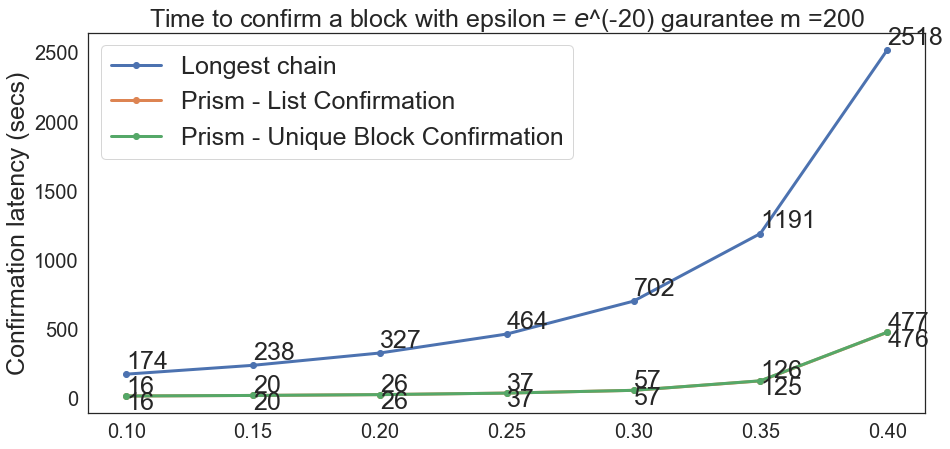

In [140]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

bitcoin_ans = bitcoin_ans.astype(int)
prism_ans_list_confirmation = prism_ans_list_confirmation.astype(int)
prism_ans_unique_block_confirmation = prism_ans_unique_block_confirmation.astype(int)
plt.plot(beta_calc, bitcoin_ans, '-o', lw=3, label="Longest chain")
plt.plot(beta_calc, prism_ans_list_confirmation, '-o',lw=3, label="Prism - List Confirmation")
plt.plot(beta_calc, prism_ans_unique_block_confirmation, '-o',lw=3, label="Prism - Unique Block Confirmation")
for i in range(bitcoin_ans.shape[0]):
    ax.annotate(bitcoin_ans[i],xy=(beta_calc[i],bitcoin_ans[i]+40), size=25)
    ax.annotate(prism_ans_list_confirmation[i],xy=(beta_calc[i],prism_ans_list_confirmation[i]-100), size=25)
    ax.annotate(prism_ans_unique_block_confirmation[i],xy=(beta_calc[i],prism_ans_unique_block_confirmation[i]+20), size=25)
plt.ylabel("Confirmation latency (secs)", size=25)
# plt.xlabel("Beta", size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title("Time to confirm a block with epsilon = $e$^("+str(-log_epsilon)+") gaurantee m ="+str(m), size=25)
plt.legend(prop={'size': 25})
plt.show()

In [146]:
import sys
k = 10
for i in range(k):
    if (1>2):
        sys.exit()

In [209]:
max(2 , 2)

2